In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

## 1) Processing Files

In [2]:
#import train and test data
chemical = pd.read_csv(r'C:\Users\tanup\Documents\ML_Datasets\Enzyme_substrate_prediction\mixed_desc.csv')
strucutural = pd.read_csv(r'C:\Users\tanup\Documents\ML_Datasets\Enzyme_substrate_prediction\mixed_ecfp.csv')
connectivity= pd.read_csv(r'C:\Users\tanup\Documents\ML_Datasets\Enzyme_substrate_prediction\mixed_fcfp.csv')
train = pd.read_csv(r'C:\Users\tanup\Documents\ML_Datasets\Enzyme_substrate_prediction\train.csv')
test = pd.read_csv(r'C:\Users\tanup\Documents\ML_Datasets\Enzyme_substrate_prediction\test.csv')


In [3]:
train
#drop EC3 to EC6
train = train.drop(['EC3','EC4','EC6','EC5','id'],axis=1)


In [4]:
mixed=chemical["EC1_EC2_EC3_EC4_EC5_EC6"]
ec1=[]
ec2=[]
for i in mixed:
    ec1.append(i.split("_")[0])
    ec2.append(i.split("_")[1])
chemical.drop(["EC1_EC2_EC3_EC4_EC5_EC6"],axis=1,inplace=True)
chemical["EC1"]=ec1
chemical["EC2"]=ec2

In [5]:
train=pd.concat([train,chemical[train.columns]])
#make EC1 and EC2 into int
train["EC1"]=train["EC1"].astype(int)
train["EC2"]=train["EC2"].astype(int)


In [6]:
train.corr().style.background_gradient()


,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
BertzCT,1.000000,0.930661,0.907938,0.924301,0.899477,0.921598,0.911863,0.821811,0.724924,0.669129,0.919016,-0.012317,-0.004613,0.011941,-0.647731,0.920696,0.061165,0.615241,-0.580705,0.829789,0.644156,0.253881,0.471205,0.215193,0.668607,0.757557,0.694953,0.804479,0.863870,-0.176620,-0.178598,-0.059627,-0.025579
Chi1,0.930661,1.000000,0.974754,0.979229,0.961684,0.971582,0.960977,0.880234,0.758057,0.672782,0.963775,-0.010493,-0.002494,0.014976,-0.614704,0.964462,0.067043,0.646698,-0.600652,0.852258,0.670218,0.276307,0.533606,0.250803,0.660343,0.755885,0.789649,0.824634,0.914244,-0.186227,-0.188633,-0.071949,-0.028601
Chi1n,0.907938,0.974754,1.000000,0.977098,0.984693,0.968422,0.965599,0.915915,0.703123,0.660200,0.943670,-0.011785,-0.003732,0.013710,-0.601341,0.941998,0.069152,0.623443,-0.533236,0.788306,0.628590,0.251985,0.587634,0.328211,0.642306,0.702325,0.823591,0.765989,0.896120,-0.186202,-0.188615,-0.056123,-0.031862
Chi1v,0.924301,0.979229,0.977098,1.000000,0.963155,0.987357,0.970968,0.877780,0.748138,0.672750,0.963621,-0.011867,-0.004207,0.012671,-0.580313,0.964247,0.075616,0.631799,-0.622350,0.855344,0.659558,0.268213,0.554583,0.254755,0.659094,0.768501,0.790965,0.832185,0.890944,-0.209678,-0.211906,-0.066815,-0.031685
Chi2n,0.899477,0.961684,0.984693,0.963155,1.000000,0.970953,0.971971,0.936690,0.689215,0.654088,0.933312,-0.012789,-0.004686,0.012876,-0.591654,0.930899,0.066491,0.615216,-0.518368,0.769785,0.617204,0.245162,0.583595,0.349120,0.633875,0.682264,0.822946,0.749559,0.886450,-0.188994,-0.191422,-0.056530,-0.029552
Chi2v,0.921598,0.971582,0.968422,0.987357,0.970953,1.000000,0.980905,0.890266,0.742971,0.671805,0.958850,-0.012699,-0.005020,0.011870,-0.572577,0.959277,0.073192,0.626895,-0.619274,0.848743,0.655545,0.261386,0.547320,0.263878,0.659248,0.760724,0.786491,0.827634,0.883763,-0.214080,-0.216345,-0.064982,-0.030810
Chi3v,0.911863,0.960977,0.965599,0.970968,0.971971,0.980905,1.000000,0.927463,0.719358,0.660589,0.944170,-0.013839,-0.005957,0.011349,-0.575306,0.943874,0.066259,0.623472,-0.578887,0.814728,0.640892,0.252539,0.541531,0.303500,0.647529,0.724429,0.793838,0.793428,0.876542,-0.213787,-0.215917,-0.060860,-0.031880
Chi4n,0.821811,0.880234,0.915915,0.877780,0.936690,0.890266,0.927463,1.000000,0.598079,0.584729,0.846827,-0.014443,-0.006656,0.010588,-0.541550,0.842413,0.056897,0.566864,-0.427290,0.656119,0.542703,0.218980,0.544380,0.413469,0.559724,0.565744,0.789977,0.638045,0.810139,-0.193471,-0.195434,-0.052450,-0.031360
EState_VSA1,0.724924,0.758057,0.703123,0.748138,0.689215,0.742971,0.719358,0.598079,1.000000,0.386648,0.766321,-0.009677,-0.004939,0.006725,-0.400760,0.773968,0.042756,0.578673,-0.745645,0.883680,0.732779,0.343942,0.175618,-0.123480,0.447312,0.648557,0.582922,0.848221,0.809243,-0.072924,-0.074680,-0.179134,-0.009400
EState_VSA2,0.669129,0.672782,0.660200,0.672750,0.654088,0.671805,0.660589,0.584729,0.386648,1.000000,0.661753,-0.004792,0.001714,0.013606,-0.584686,0.663253,0.037439,0.455314,-0.318237,0.584365,0.404668,0.107561,0.396303,0.179599,0.678505,0.671886,0.440963,0.569878,0.617099,-0.076376,-0.077855,0.043504,-0.037978


### removing features that have high correlation with each other

In [7]:
#show variables with high correlation
corr = train.corr()
corr = corr.abs().unstack()
corr = corr.sort_values(ascending = False)

#if first variable is different from second variable, and correlation is high, list the second variable
corr_filtered = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]

# Now filter for high correlation (greater than 0.8)
high_corr = corr_filtered[corr_filtered > 0.95]

#make second column of high_corr into a list
remove_values = high_corr.index.get_level_values(1).tolist()
#make the list unique
remove_values = list(set(remove_values))
remove_values
train.drop(remove_values,axis=1,inplace=True)

In [8]:
train.corr().style.background_gradient()


,BertzCT,Chi4n,EState_VSA1,EState_VSA2,HallKierAlpha,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,EC1,EC2
BertzCT,1.000000,0.821811,0.724924,0.669129,-0.647731,0.061165,0.615241,-0.580705,0.829789,0.644156,0.253881,0.471205,0.215193,0.668607,0.757557,0.694953,0.804479,0.863870,-0.059627,-0.025579
Chi4n,0.821811,1.000000,0.598079,0.584729,-0.541550,0.056897,0.566864,-0.427290,0.656119,0.542703,0.218980,0.544380,0.413469,0.559724,0.565744,0.789977,0.638045,0.810139,-0.052450,-0.031360
EState_VSA1,0.724924,0.598079,1.000000,0.386648,-0.400760,0.042756,0.578673,-0.745645,0.883680,0.732779,0.343942,0.175618,-0.123480,0.447312,0.648557,0.582922,0.848221,0.809243,-0.179134,-0.009400
EState_VSA2,0.669129,0.584729,0.386648,1.000000,-0.584686,0.037439,0.455314,-0.318237,0.584365,0.404668,0.107561,0.396303,0.179599,0.678505,0.671886,0.440963,0.569878,0.617099,0.043504,-0.037978
HallKierAlpha,-0.647731,-0.541550,-0.400760,-0.584686,1.000000,-0.020926,-0.463478,0.208721,-0.475735,-0.381484,-0.068885,-0.339695,-0.255877,-0.590395,-0.528349,-0.380228,-0.470592,-0.635880,-0.018569,0.042316
Kappa3,0.061165,0.056897,0.042756,0.037439,-0.020926,1.000000,0.033824,-0.065546,0.058859,0.028197,0.026053,0.056193,0.017839,0.036460,0.061542,0.069135,0.062104,0.048939,0.006671,0.005152
MaxAbsEStateIndex,0.615241,0.566864,0.578673,0.455314,-0.463478,0.033824,1.000000,-0.554663,0.623016,0.476814,0.259410,0.191876,0.087686,0.434742,0.534363,0.481235,0.605836,0.657360,-0.124431,-0.028661
MinEStateIndex,-0.580705,-0.427290,-0.745645,-0.318237,0.208721,-0.065546,-0.554663,1.000000,-0.788922,-0.570771,-0.253112,-0.104809,0.152600,-0.340761,-0.607220,-0.388343,-0.770009,-0.573402,0.211851,-0.001323
NumHeteroatoms,0.829789,0.656119,0.883680,0.584365,-0.475735,0.058859,0.623016,-0.788922,1.000000,0.726597,0.332718,0.268366,-0.085272,0.592094,0.824460,0.587741,0.934430,0.820296,-0.131289,-0.015434
PEOE_VSA10,0.644156,0.542703,0.732779,0.404668,-0.381484,0.028197,0.476814,-0.570771,0.726597,1.000000,0.004001,0.191756,-0.064945,0.462105,0.542897,0.478305,0.668394,0.684729,-0.116672,-0.008720


### splitting the data 

In [10]:
# Convert x1 and x2 back to DataFrames with the same column names as the original data
x1 = pd.DataFrame(train)
x1.drop(["EC1"], axis=1, inplace=True)  # Drop the EC1 column from x1
y1 = train["EC1"]  # Store the EC1 target column separately in y1

x2 = pd.DataFrame(train)
x2.drop(["EC2"], axis=1, inplace=True)  # Drop the EC2 column from x2
y2 = train["EC2"]  # Store the EC2 target column separately in y2


### remove outliers

In [11]:
from sklearn.preprocessing import RobustScaler
rs_x1 = RobustScaler()
rs_x2 = RobustScaler()

x1=rs_x1.fit_transform(x1)
x2=rs_x2.fit_transform(x2)

In [12]:
import pandas as pd

# Assuming y1 and y2 are your target variables (e.g., DataFrames or Series)
# Calculate scale_pos_weight for y1
num_pos_y1 = y1.sum()  # Count of positive samples
num_neg_y1 = len(y1) - num_pos_y1  # Count of negative samples
scale_pos_weight_y1 = num_neg_y1 / num_pos_y1 if num_pos_y1 > 0 else 0

# Calculate scale_pos_weight for y2
num_pos_y2 = y2.sum()  # Count of positive samples
num_neg_y2 = len(y2) - num_pos_y2  # Count of negative samples
scale_pos_weight_y2 = num_neg_y2 / num_pos_y2 if num_pos_y2 > 0 else 0

# Print scale_pos_weight values
print(f"Scale Pos Weight for y1: {scale_pos_weight_y1}")
print(f"Scale Pos Weight for y2: {scale_pos_weight_y2}")


Scale Pos Weight for y1: 0.5029344945096554
Scale Pos Weight for y2: 0.25648939537828425


In [13]:
from sklearn.model_selection import train_test_split
x1_train,x1_test,y1_train,y1_test=train_test_split(x1,y1,test_size=0.25,random_state=1)
x2_train,x2_test,y2_train,y2_test=train_test_split(x2,y2,test_size=0.25,random_state=1)

In [14]:

# Train models
model_x1 = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight_y1)
model_x1.fit(x1_train, y1_train)

model_x2 = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight_y2)
model_x2.fit(x2_train, y2_train)

# Make predictions
y1_pred = model_x1.predict(x1_test)
y2_pred = model_x2.predict(x2_test)


In [15]:
# Evaluate models
print("Classification Report for y1:")
print(classification_report(y1_test, y1_pred))

print("Classification Report for y2:")
print(classification_report(y2_test, y2_pred))

Classification Report for y1:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      1348
           1       0.76      0.72      0.74      2622

    accuracy                           0.67      3970
   macro avg       0.63      0.64      0.64      3970
weighted avg       0.68      0.67      0.67      3970

Classification Report for y2:
              precision    recall  f1-score   support

           0       0.27      0.38      0.32       797
           1       0.83      0.75      0.78      3173

    accuracy                           0.67      3970
   macro avg       0.55      0.56      0.55      3970
weighted avg       0.72      0.67      0.69      3970



### Define parameter grid 

In [16]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],          # Step size shrinkage
    'max_depth': [3, 5, 7, 9],                  # Maximum tree depth
    'min_child_weight': [1, 3, 5],              # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.6, 0.8, 1.0],               # Fraction of samples to be used for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],        # Fraction of features to be used for each tree
}


In [17]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight_y1)

In [18]:
## Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='f1_macro',  # You can choose other metrics as needed
                           cv=5,                 # Number of cross-validation folds
                           verbose=1,
                           n_jobs=-1)            # Use all available cores
grid_search.fit(x1_train, y1_train)

print("Best parameters from Grid Search: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters from Grid Search:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score:  0.6672873479222161


In [30]:
best_model = xgb.XGBClassifier(**grid_search.best_params_, scale_pos_weight=scale_pos_weight_y1)
best_model.fit(x1_train, y1_train)

# Make predictions
y1_pred = best_model.predict(x1_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y1_test, y1_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57      1348
           1       0.78      0.71      0.75      2622

    accuracy                           0.68      3970
   macro avg       0.65      0.66      0.66      3970
weighted avg       0.70      0.68      0.69      3970



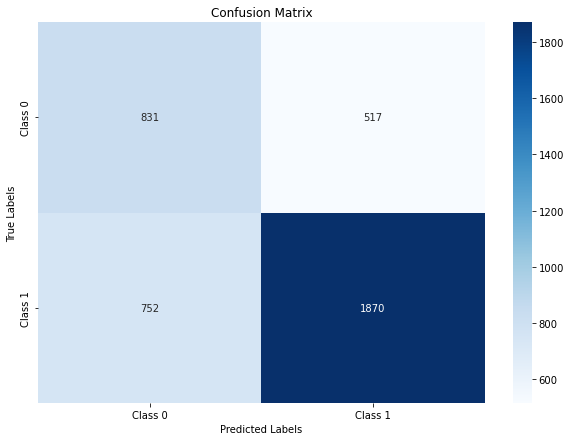

              precision    recall  f1-score   support

           0       0.52      0.62      0.57      1348
           1       0.78      0.71      0.75      2622

    accuracy                           0.68      3970
   macro avg       0.65      0.66      0.66      3970
weighted avg       0.70      0.68      0.69      3970



In [36]:
#print a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y1_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],  # Adjust based on your classes
            yticklabels=['Class 0', 'Class 1'])  # Adjust based on your classes
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optional: Print the classification report
print(classification_report(y1_test, y1_pred))


In [ ]:
### XGBoost may need furhte tuning, so we can use RandomizedSearchCV to find the best hyperparameters

In [3]:
#this is to test changes